In [3]:
import torch as tc 
from torch import nn,optim
from torch.utils.data import TensorDataset,DataLoader,random_split

from torchvision import transforms as T
from torchvision.datasets import MNIST

from tqdm import tqdm 
from torchmetrics import Accuracy 

import pandas as pd 
import matplotlib.pyplot as plt 

In [4]:
train_dataset=MNIST(root='datasets',download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw



In [5]:
mean=tc.FloatTensor(train_dataset.data/255).mean()
std=tc.FloatTensor(train_dataset.data/255).std()

In [6]:
mean

tensor(0.1307)

In [30]:
transforms0=T.Compose([T.RandomCrop((28,28)),
                       T.RandomHorizontalFlip(p=0.5),
                       T.ToTensor(),
                       T.Normalize(mean=mean,std=std)])
transforms=T.Compose([T.ToTensor(),T.Normalize(mean=mean,std=std)])

In [31]:
train_dataset=MNIST(root='datasets',train=True,download=True,transform=transforms0)
test_dataset=MNIST(root='datasets',train=False,download=True,transform=transforms)

In [32]:
train_loader=DataLoader(train_dataset,batch_size=256,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=512,shuffle=False)

In [10]:
def conv(in_channels,out_channels,kernel_size,stride,padding):
  module=nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU())
  return module

In [11]:
def CNN_model():
  cnn_model=nn.Sequential(conv(1,32,(3,3),stride=2,padding=1), #bs*32*14*14
                conv(32,32,(3,3),stride=1,padding=1), #bs*32*14*14
                conv(32,64,(1,1),stride=1,padding=1), #bs*64*16*16
                conv(64,64,(3,3),stride=2,padding=1),  #bs*64*8*8
                conv(64,128,(1,1),stride=1,padding=1), #bs*128*10*10
                conv(128,128,(3,3),stride=1,padding=1), #bs*128*10*10
                conv(128,128,(1,1),stride=1,padding=1), #bs*128*12*12
                conv(128,128,(3,3),stride=2,padding=1), #bs*128*6*6
                conv(128,256,(1,1),stride=1,padding=1), #bs*256*8*8
                conv(256,256,(3,3),stride=1,padding=1), #bs*256*8*8
                conv(256,256,(1,1),stride=1,padding=1), #bs*256*10*10
                conv(256,256,(3,3),stride=1,padding=1), #bs*256*10*10
                conv(256,512,(1,1),stride=1,padding=1), #bs*512*12*12
                conv(512,512,(3,3),stride=1,padding=1), #bs*512*12*12
                conv(512,512,(1,1),stride=1,padding=1), #bs*512*14*14
                conv(512,512,(3,3),stride=2,padding=1), #bs*512*7*7
                conv(512,1024,(1,1),stride=1,padding=1),#bs*1024*9*9
                conv(1024,1024,(3,3),stride=1,padding=1),#bs*1024*9*9
                conv(1024,1024,(1,1),stride=1,padding=1),#bs*1024*11*11
                
                nn.AdaptiveAvgPool2d(output_size=(1,1)), #bs*1024*1,1

                nn.Flatten(),
                nn.Linear(1024,10))
  return cnn_model

In [12]:
CNN_model()(tc.randn(100,1,28,28)).shape

torch.Size([100, 10])

In [13]:
sum(p.numel() for p in CNN_model().parameters() )/1e6

17.798506

In [14]:
device='cuda' if tc.cuda.is_available() else 'cpu'

In [15]:
model=CNN_model().to(device)

In [16]:
loss_func=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001)

In [17]:
x,y=next(iter(train_loader))
yp=model(x.to(device))
loss_func(yp,y.to(device))

tensor(2.3544, device='cuda:0', grad_fn=<NllLossBackward0>)

In [18]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [19]:
def train_one_epoch(model,train_loader,loss_func,optimizer,epoch):
  model.train()
  train_loss=AverageMeter()
  train_acc=Accuracy(task='multiclass',num_classes=10).to(device)
  with tqdm(train_loader,unit='batch') as tepoch:
    for x,y in tepoch:
        if epoch is not None:
          tepoch.set_description(f'Epoch{epoch}')
        x=x.to(device)
        y=y.to(device)
        yp=model(x)
        loss=loss_func(yp.squeeze(),y)
        train_loss.update(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_acc(yp,y.int())
        tepoch.set_postfix(loss=train_loss.avg,
                      accuracy=100*train_acc.compute().item())


  return model,train_loss.avg,train_acc.compute().item()

def validation(model,valid_loader,loss_func):

  valid_loss=AverageMeter()
  valid_acc=Accuracy(task='multiclass',num_classes=10).to(device)

  for j,(x,y) in enumerate(valid_loader):
    x=x.to(device)
    y=y.to(device)
    yp=model(x)
    loss=loss_func(yp.squeeze(),y)
    valid_loss.update(loss.item())
    valid_acc(yp.squeeze(),y)

  print(f'valid loss={valid_loss.avg:.4},accuracy={valid_acc.compute():.4}')
  print()

  return valid_loss.avg,valid_acc.compute().item()

In [20]:
mini_batch,_=random_split(train_dataset,(1000,len(train_dataset)-1000))
mini_loader=DataLoader(mini_batch,batch_size=20,shuffle=True)

In [21]:
for i in range(10):
  model,_,_=train_one_epoch(model,mini_loader,loss_func,optimizer,i)

Epoch9: 100%|██████████| 50/50 [00:02<00:00, 18.43batch/s, accuracy=40.5, loss=2.05]


In [22]:
lr=[0.1,0.01,0.001,0.0001]
for i in lr: 
  model=CNN_model().to(device)
  optimizer=optim.SGD(model.parameters(),lr=i)
  model,train_loss,train_acc=train_one_epoch(model,train_loader,loss_func,optimizer,1)

Epoch1: 100%|██████████| 235/235 [01:54<00:00,  2.04batch/s, accuracy=12.1, loss=2.3]


In [26]:
lr=[0.1,0.15,0.20,0.25]
wd=[0,1e-4,1e-5,1e-6]
result=[]

for i in lr:
  lr_result=[]
  for j in wd:
    print(f'lr={i},wd={j}')
    model=CNN_model().to(device)
    optimizer=optim.SGD(model.parameters(),lr=i,weight_decay=j)
    N=5
    for l in range(N):
      model,train_loss,train_acc=train_one_epoch(model,train_loader,loss_func,optimizer,l)
      if l==0:
        e1=train_loss
      if l==N-1:
        e2=train_loss
    lr_result.append(f'{e1:.4}-{e2:.4}={e1-e2:.4}')
  result.append(lr_result)

lr=0.1,wd=0


Epoch4: 100%|██████████| 235/235 [01:52<00:00,  2.09batch/s, accuracy=99.7, loss=0.0106]


lr=0.1,wd=0.0001


Epoch4: 100%|██████████| 235/235 [01:52<00:00,  2.10batch/s, accuracy=99.7, loss=0.0112]


lr=0.1,wd=1e-05


Epoch4: 100%|██████████| 235/235 [01:53<00:00,  2.08batch/s, accuracy=99.7, loss=0.00998]


lr=0.1,wd=1e-06


Epoch4: 100%|██████████| 235/235 [01:53<00:00,  2.08batch/s, accuracy=99.6, loss=0.0118]


lr=0.15,wd=0


Epoch4: 100%|██████████| 235/235 [01:52<00:00,  2.09batch/s, accuracy=99.6, loss=0.0137]


lr=0.15,wd=0.0001


Epoch4: 100%|██████████| 235/235 [01:52<00:00,  2.09batch/s, accuracy=99.7, loss=0.0107]


lr=0.15,wd=1e-05


Epoch4: 100%|██████████| 235/235 [01:52<00:00,  2.09batch/s, accuracy=99.7, loss=0.0122]


lr=0.15,wd=1e-06


Epoch4: 100%|██████████| 235/235 [01:52<00:00,  2.08batch/s, accuracy=99.6, loss=0.0119]


lr=0.2,wd=0


Epoch4: 100%|██████████| 235/235 [01:51<00:00,  2.10batch/s, accuracy=99.7, loss=0.0117]


lr=0.2,wd=0.0001


Epoch4: 100%|██████████| 235/235 [01:52<00:00,  2.09batch/s, accuracy=99.6, loss=0.0145]


lr=0.2,wd=1e-05


Epoch4: 100%|██████████| 235/235 [01:52<00:00,  2.09batch/s, accuracy=99.6, loss=0.0133]


lr=0.2,wd=1e-06


Epoch4: 100%|██████████| 235/235 [01:52<00:00,  2.09batch/s, accuracy=99.7, loss=0.0116]


lr=0.25,wd=0


Epoch0:  15%|█▌        | 36/235 [00:17<01:34,  2.10batch/s, accuracy=43.9, loss=1.63]


KeyboardInterrupt: ignored

In [27]:
pd.DataFrame(result)

,0,1,2,3
0,0.3057-0.0106=0.2951,0.2937-0.01122=0.2825,0.3118-0.009978=0.3019,0.302-0.0118=0.2902
1,0.3358-0.01371=0.3221,0.3069-0.01072=0.2962,0.2714-0.01224=0.2592,0.2944-0.01186=0.2825
2,0.2952-0.01169=0.2835,0.341-0.01448=0.3265,0.3223-0.0133=0.309,0.3242-0.01158=0.3126


In [36]:
model=CNN_model().to(device)

In [37]:
optimizer=optim.SGD(model.parameters(),lr=0.2,weight_decay=1e-4)

In [ ]:
loss_train_hist,acc_train_hist=[],[]
loss_test_hist,acc_test_hist=[],[]

In [38]:
N=10
best_model=None
best_loss=255
for i in range(N): 
  model,train_loss,train_acc=train_one_epoch(model,train_loader,loss_func,optimizer,i)
  test_loss,test_acc=validation(model,test_loader,loss_func)

  loss_train_hist.append(train_loss)
  acc_train_hist.append(train_acc)

  loss_test_hist.append(test_acc) 
  acc_test_hist.append(test_acc) 

  if train_loss<best_loss:
    best_model=model

Epoch0: 100%|██████████| 235/235 [01:50<00:00,  2.12batch/s, accuracy=84.3, loss=0.466]


valid loss=0.1326,accuracy=0.9599



Epoch1: 100%|██████████| 235/235 [01:54<00:00,  2.05batch/s, accuracy=97.4, loss=0.0867]


valid loss=0.05538,accuracy=0.9813



Epoch2: 100%|██████████| 235/235 [01:54<00:00,  2.05batch/s, accuracy=98.2, loss=0.0568]


valid loss=0.05704,accuracy=0.9806



Epoch3: 100%|██████████| 235/235 [01:55<00:00,  2.04batch/s, accuracy=98.5, loss=0.0455]


valid loss=0.06085,accuracy=0.9798



Epoch4: 100%|██████████| 235/235 [01:55<00:00,  2.03batch/s, accuracy=98.8, loss=0.0368]


valid loss=0.05429,accuracy=0.9833



Epoch5: 100%|██████████| 235/235 [01:55<00:00,  2.04batch/s, accuracy=99, loss=0.0318]


valid loss=0.03681,accuracy=0.9877



Epoch6: 100%|██████████| 235/235 [01:55<00:00,  2.04batch/s, accuracy=99.1, loss=0.0278]


valid loss=0.04339,accuracy=0.9871



Epoch7: 100%|██████████| 235/235 [01:55<00:00,  2.03batch/s, accuracy=99.3, loss=0.0233]


valid loss=0.05351,accuracy=0.9834



Epoch8: 100%|██████████| 235/235 [01:55<00:00,  2.03batch/s, accuracy=99.4, loss=0.0205]


valid loss=0.1307,accuracy=0.9578



Epoch9: 100%|██████████| 235/235 [01:55<00:00,  2.04batch/s, accuracy=99.4, loss=0.0193]


valid loss=0.03962,accuracy=0.9885



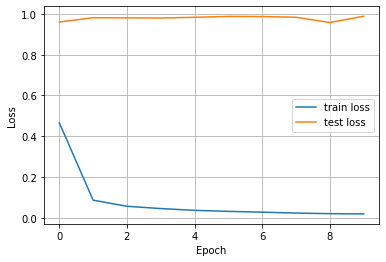

In [39]:
plt.plot(range(N),loss_train_hist,label='train loss')
plt.plot(range(N),loss_test_hist,label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

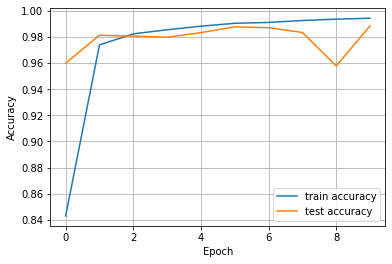

In [40]:
plt.plot(range(N),acc_train_hist,label='train accuracy')
plt.plot(range(N),acc_test_hist,label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [42]:
tc.save(model,'model.pth')